In [1]:
import torch
import glob, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from tueplots import bundles, figsizes

plt.rcParams.update(bundles.icml2024())

In [3]:
from taskids import lcbench_ids, pd1_ids, taskset_ids

In [4]:
methods = {
    "bopfn_broken_unisep_1000curves_10params_2M": "FT-PFN",
    "bopfn_broken_no_hps_1000curves_10params_2M": "FT-PFN (no HPs)",
    "dyhpo": "DyHPO",
    "dpl": "DPL",
}

In [5]:
name_cols = {
    "lcbench_tabular": "LCBench",
    "pd1_tabular": "PD1",
    "taskset_tabular": "TaskSet",
}
row_list = ["DPL", "DyHPO", "FT-PFN (no HPs)", "FT-PFN"]

In [6]:
nsamples = [100, 200, 400, 800, 1000, 1200, 1400, 1800]

In [7]:
l_benchmarks = ["lcbench_tabular", "pd1_tabular", "taskset_tabular"]

In [8]:
df = []

for benchmark in l_benchmarks:
    for sep in nsamples:
        for m in methods.keys():
            benchmark_map = {
                "lcbench_tabular": lcbench_ids,
                "pd1_tabular": pd1_ids,
                "taskset_tabular": taskset_ids,
            }

            for tid in benchmark_map.get(benchmark, []):
                if benchmark == "lcbench_tabular":
                    output_name = tid
                elif benchmark == "pd1_tabular":
                    output_name = f"{tid['model']}_{tid['dataset']}_{tid['batch_size']}"
                    if "coarseness" in tid:
                        output_name = f"{output_name}_{tid['coarseness']}"
                elif benchmark == "taskset_tabular":
                    output_name = f"{tid['task_id']}_{tid['optimizer']}"

                try:
                    data = np.load(
                        f"results/{benchmark}/{output_name}_100bs_{sep}sep_{m}.npy"
                    )
                    data = pd.DataFrame(
                        data, columns=["Log-likelihood", "MSE", "runtime"]
                    )
                    data["sep"] = sep
                    data["method"] = methods[m]
                    data["benchmark"] = benchmark
                    data["batch"] = np.arange(100)
                    data["taskid"] = f"{benchmark}_{output_name}"
                    df.append(data)
                except Exception as e:
                    raise (e)

df = pd.concat(df, ignore_index=True)

In [9]:
data = (
    df.groupby(["benchmark", "sep", "method"])[["Log-likelihood", "MSE", "runtime"]]
    .median()
    .reset_index()
)
data = data.pivot(
    index=["sep", "method"],
    columns="benchmark",
    values=["Log-likelihood", "MSE", "runtime"],
).swaplevel(0, 1, axis=1)

In [10]:
formated_data = []
runtimes = []
columns = []

for d in l_benchmarks:
    formated_data.append(data[d][["Log-likelihood", "MSE"]])
    runtimes.append(data[d][["runtime"]])
    columns.append((name_cols[d], "Log-likelihood"))
    columns.append((name_cols[d], "MSE"))

print(columns)
columns.append(("", "runtime"))
col_list = pd.MultiIndex.from_tuples(columns)
rows_order = []
for sep in [400, 800, 1000, 1400, 1800]:
    for alg in row_list:
        rows_order.append((sep, alg))

[('LCBench', 'Log-likelihood'), ('LCBench', 'MSE'), ('PD1', 'Log-likelihood'), ('PD1', 'MSE'), ('TaskSet', 'Log-likelihood'), ('TaskSet', 'MSE')]


In [11]:
formated_data = pd.concat(formated_data, axis=1)
formated_data["runtime"] = pd.concat(runtimes, axis=1).mean(1)

In [12]:
formated_data = formated_data.loc[rows_order]
formated_data.columns = col_list
styled_data = formated_data.style.format(precision=3, decimal=".").hide(names=True)
styled_data

# Visualize a task

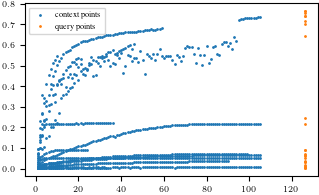

In [13]:
single_eval_pos = 1000 # [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800]
task_id = 7 # [0, 99]
B = torch.load(f"tasks/pd1_tabular/resnet_imagenet_1024_1_100bs_{single_eval_pos}sep.pt")
D = B[task_id]
mask = torch.where(D.sum(-1) != 0)[0].long() # remove zero padding
D = D[mask, ...]
train = D[:single_eval_pos]
test = D[single_eval_pos:]

plt.scatter(train[..., 1], 1-train[..., -1], s=1, label="context points")
plt.scatter(test[..., 1], 1-test[..., -1], s=1, label="query points")

plt.legend()